Iteration 1, RMSE: 94.5238024367918
Iteration 2, RMSE: 109.75224731611479
Iteration 3, RMSE: 154.49941955896088
Iteration 4, RMSE: 153.91708579169418
Iteration 5, RMSE: 154.7704613481526
Iteration 6, RMSE: 148.18743454540223
Iteration 7, RMSE: 141.5335807632655
Iteration 8, RMSE: 182.70598544168374
Iteration 9, RMSE: 175.67072945858743
Iteration 10, RMSE: 159.7279549772412
Iteration 11, RMSE: 185.83575452473198
Iteration 12, RMSE: 138.0009388261986
Iteration 13, RMSE: 150.48659095896102
Iteration 14, RMSE: 147.32956009186373
Iteration 15, RMSE: 174.51597909217082
Iteration 16, RMSE: 150.45723064232703
Iteration 17, RMSE: 172.8498750134136
Iteration 18, RMSE: 169.23326688897288
Iteration 19, RMSE: 177.20996617631909
Iteration 20, RMSE: 174.11805614476023
Iteration 21, RMSE: 163.58244736305258
Iteration 22, RMSE: 153.3388445807847
Iteration 23, RMSE: 176.7500347849267
Iteration 24, RMSE: 196.2393237913651
Iteration 25, RMSE: 199.75946220140955
Iteration 26, RMSE: 169.73269542953952
Itera

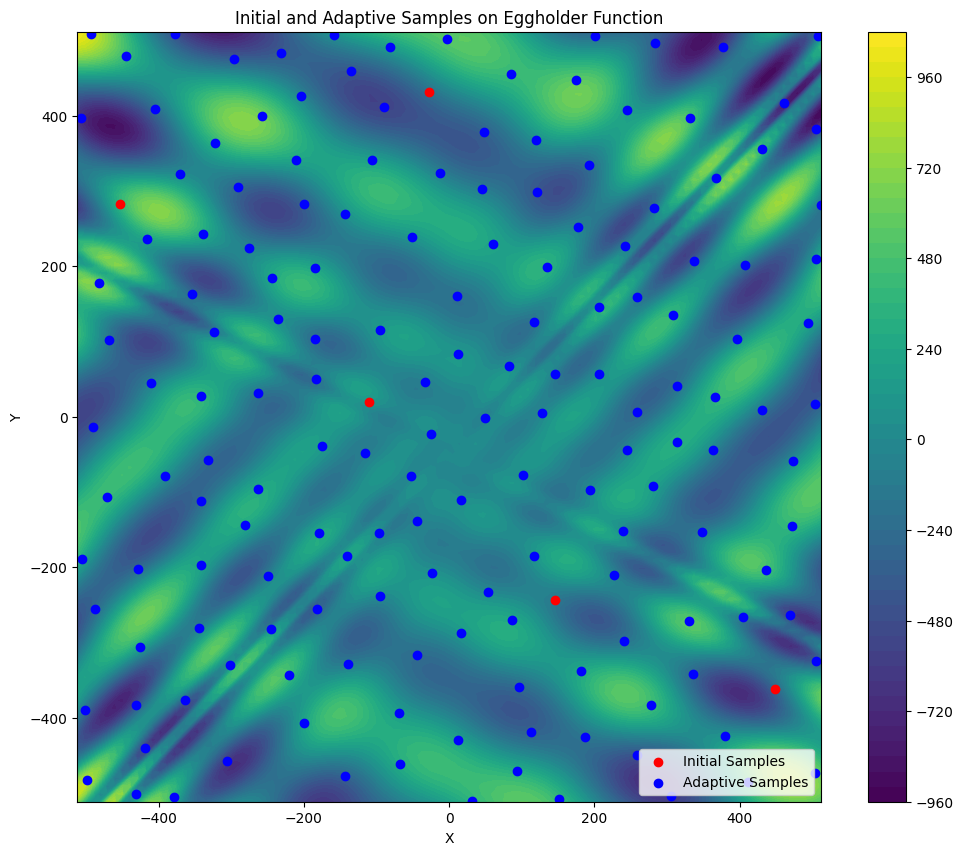

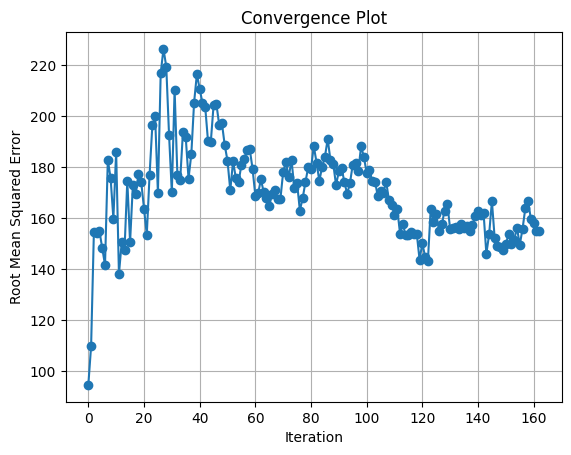

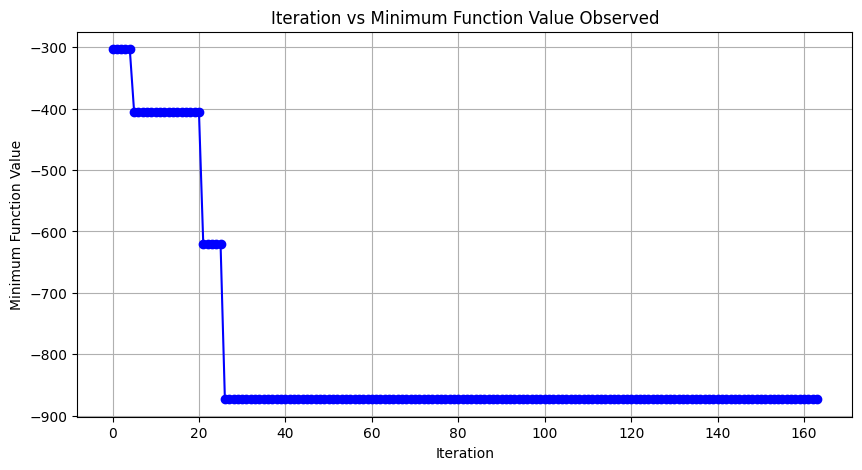

Best observed function value after active learning: -873.0969321551041
             X1          X2
0    145.322565 -243.754969
1    448.606020 -362.393780
2   -110.513595   19.397494
3   -453.689755  283.148302
4    -27.846990  431.519579
..          ...         ...
163 -341.753733 -112.492077
164 -231.537737  483.874723
165  -24.317573  -23.488718
166  258.564399    6.072888
167  244.820670  408.111075

[168 rows x 2 columns]


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1729)
rf.fit(initial_points, initial_values)

# Active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 0.1
improvement = []

# Perform active learning with adaptive sampling
min_function_values = [np.min(initial_values)]  # Track min function value for each iteration
samples = initial_points
sample_values = initial_values

for iteration in range(num_iterations):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=20)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Calculate the distance of each new candidate point to the existing points
    distances_to_existing = [min([euclidean_distance(new_point, sample) for sample in samples]) for new_point in new_points]

    # Find the index of the point with the maximum distance
    index_of_max_distance = np.argmax(distances_to_existing)

    # The point with the maximum distance to existing points
    chosen_new_point = new_points[index_of_max_distance]

    # Update the model with the new point
    chosen_new_value = np.array([eggholder_function(chosen_new_point[0], chosen_new_point[1])])

    # Update training data
    new_points_all = np.vstack([samples, chosen_new_point])
    new_values_all = np.append(sample_values, chosen_new_value)

    # Sort the values in descending order
    new_values_all.sort()

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(np.hstack((initial_values, new_values_all))))

    # Re-fit the model including the new points
    rf.fit(new_points_all, new_values_all)

    # Calculate improvement
    rmse = (mean_squared_error(new_values_all, rf.predict(new_points_all)))**0.5
    improvement.append(rmse)

    print(f"Iteration {iteration+1}, RMSE: {rmse}")

    # Check for convergence (change in func value less than the tolerance)
    if len(improvement) > 1 and abs(improvement[-2]-improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration+1}.")
        break

    # Update the sample points and values for the next iteration
    samples = new_points_all
    sample_values = new_values_all

# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:,0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(new_points_all[5:, 0], new_points_all[5:, 1], c='blue', label='Adaptive Samples')
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()

# Print final result
print(f"Best observed function value after active learning: {min(min_function_values)}")

# Save the final samples to a DataFrame
samples_df = pd.DataFrame({"X1": new_points_all[:,0], "X2": new_points_all[:,1]})
print(samples_df)
